# Lasso Feature selection on CNN features

### import necessary libraries

In [1]:
import cv2
from skimage.feature import greycomatrix, greycoprops
from sklearn.model_selection import train_test_split
from sklearn.ensemble import BaggingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

import os
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.feature import greycomatrix, greycoprops
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import img_to_array
from skimage.io import imread
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense
from tensorflow.keras.layers import MaxPooling2D, Activation, Flatten, Dropout
from keras import optimizers
from tensorflow.keras import datasets, layers, models
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Model

from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import classification_report

from sklearn.metrics import confusion_matrix

import seaborn as sns

### Define dataset path and load for feature extraction

In [2]:

# set image path and categories
data_path = "D:/Individual_Trees_photos/exatctcrop"
categories = os.listdir(data_path)

# initialize lists for features and labels
features_cnn = []
features_glcm = []
labels = []

# load images and extract features
for category in categories:
    category_path = os.path.join(data_path, category)
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        img = cv2.resize(img, (250, 250))
        img_cnn = img_to_array(img)
        img_glcm = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features_cnn.append(img_cnn)
        features_glcm.append(img_glcm)
        labels.append(category)



In [3]:
# convert features and labels to numpy arrays
features_cnn = np.array(features_cnn)
labels = np.array(labels)




### CNN feature extraction model

In [4]:
# create CNN model for feature extraction
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 3)))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Conv2D(512, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D((2, 2)))
model_cnn.add(Flatten())


# extract CNN features for all images
features_cnn = model_cnn.predict(features_cnn)
# Compile the model
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



17/17 [==============================] - 4s 213ms/step


### Ploting feature maps

1/1 [==============================] - 0s 80ms/step


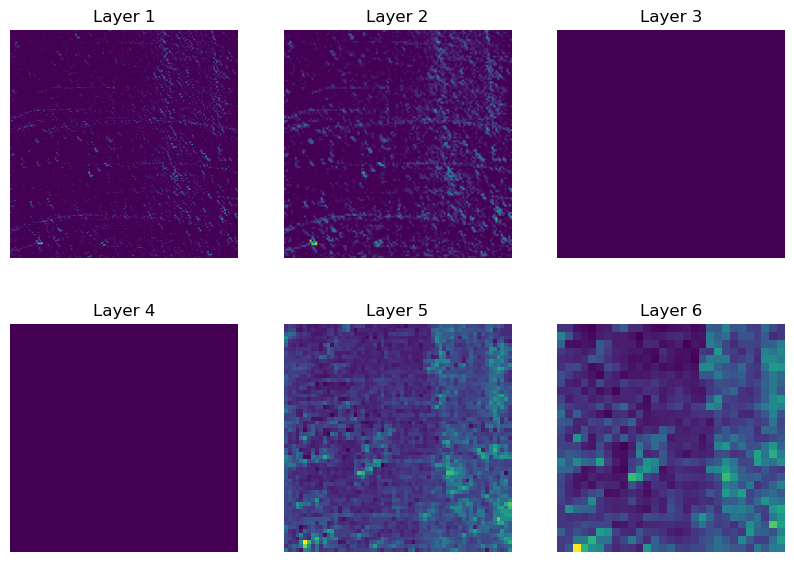

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model

# Load an example image
img_path = 'D:/Individual_Trees_photos/exatctcrop/European beech/DSC01419.jpg'
img = load_img(img_path, target_size=(250, 250))
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)

# Create a model that outputs the feature maps for each layer
layer_outputs = [layer.output for layer in model_cnn.layers[:6]]
activation_model = Model(inputs=model_cnn.input, outputs=layer_outputs)

# Get the activations for the example image
activations = activation_model.predict(img_array)

# Plot the feature maps using a heatmap
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10, 7))
for i, activation in enumerate(activations):
    row = i // 3
    col = i % 3
    axs[row, col].imshow(activation[0, :, :, 0], cmap='viridis')
    axs[row, col].axis('off')
    axs[row, col].set_title(f'Layer {i+1}')
plt.show()


### Label encoding and feature selection using lasso

In [6]:
from sklearn.preprocessing import LabelEncoder

# encode labels into numerical values
le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

# apply Lasso feature selection on the CNN features
lasso = Lasso(alpha=0.01)
lasso.fit(features_cnn, labels_encoded)
selector = SelectFromModel(lasso, prefit=True)
X_cnn_selected = selector.transform(features_cnn)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.079e+00, tolerance: 7.377e-02
  model = cd_fast.enet_coordinate_descent(


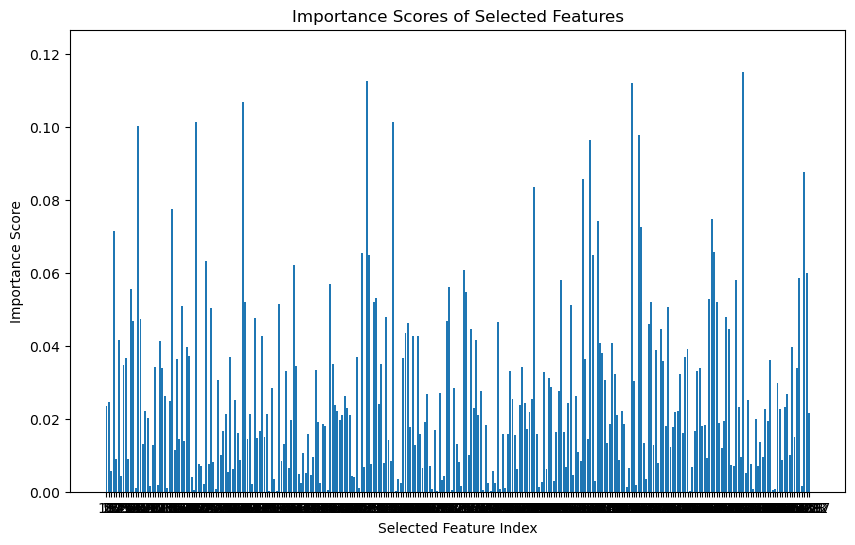

In [7]:
# # get the importance scores of the selected features
# importance_scores = np.abs(lasso.coef_)
# selected_indices = selector.get_support(indices=True)

# # Create a bar plot of the importance scores
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(selected_indices)), importance_scores[selected_indices])
# plt.xticks(range(len(selected_indices)), selected_indices)
# plt.xlabel('Selected Feature Index')
# plt.ylabel('Importance Score')

# # Set y-axis range to accommodate possible importance score values
# plt.ylim(0, np.max(importance_scores) * 1.1)

# plt.title('Importance Scores of Selected Features')
# plt.savefig('importance_scores.png', dpi=300)
# plt.show()

### Ploting feature importance scores

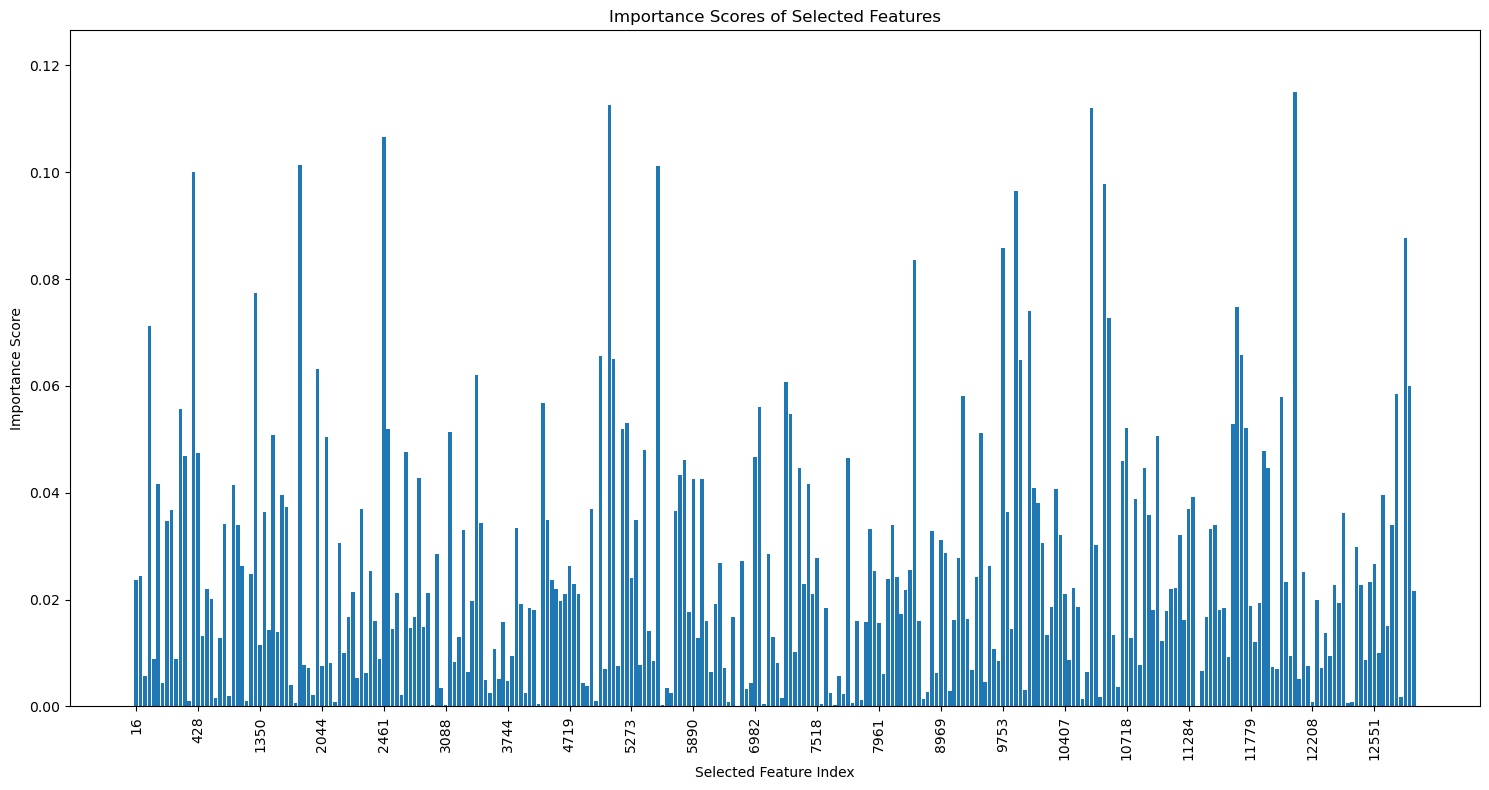

In [10]:


# Assuming lasso and selector are already defined and trained
# Get the importance scores of the selected features
importance_scores = np.abs(lasso.coef_)
selected_indices = selector.get_support(indices=True)

# Create a bar plot of the importance scores
plt.figure(figsize=(15, 8))
plt.bar(range(len(selected_indices)), importance_scores[selected_indices])

# Set x-ticks to be at regular intervals instead of every index
interval = max(1, len(selected_indices) // 20)  # Adjust the interval as needed
plt.xticks(range(0, len(selected_indices), interval), selected_indices[::interval], rotation=90)

plt.xlabel('Selected Feature Index')
plt.ylabel('Importance Score')

# Set y-axis range to accommodate possible importance score values
plt.ylim(0, np.max(importance_scores) * 1.1)

plt.title('Importance Scores of Selected Features')
plt.tight_layout()  # Adjust layout to make room for rotated x-axis labels
plt.savefig('importance_scores_improved.png', dpi=300)
plt.show()


### Training-testing splits

In [8]:
# split features and labels into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X_cnn_selected, labels, test_size=0.2, random_state=42)



### Defining SVM model

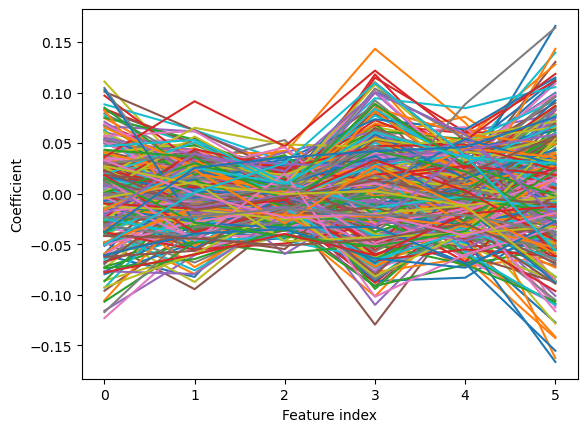

In [9]:
model = SVC(kernel='linear')
model.fit(x_train, y_train)
# plot the coefficients
plt.plot(model.coef_)
plt.xlabel('Feature index')
plt.ylabel('Coefficient')
plt.show()

In [10]:
# make predictions on the test set

y_train_pred = model.predict(x_train)
y_pred = model.predict(x_test)

### Training accuracy

In [11]:
train_accuracy = accuracy_score(y_train, y_train_pred)
print(' Train Accuracy:', train_accuracy)

 Train Accuracy: 1.0


### Test accuracy

In [12]:
# compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print('Test Accuracy:', accuracy)

Test Accuracy: 0.9433962264150944


### Classification report 

In [13]:
y_pred_nb = model.predict(x_test)
print (classification_report(y_test, y_pred_nb))

                     precision    recall  f1-score   support

     European beech       0.97      1.00      0.99        38
European silver fir       0.95      0.90      0.92        20
      Norway spruce       0.86      0.90      0.88        21
        Sessile oak       0.96      0.93      0.94        27

           accuracy                           0.94       106
          macro avg       0.94      0.93      0.93       106
       weighted avg       0.94      0.94      0.94       106



### Confusion Matrix

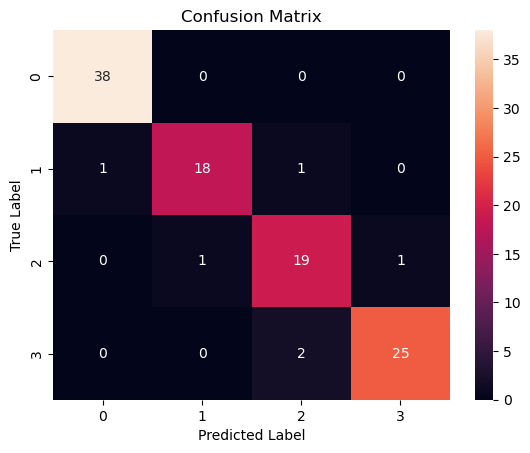

In [14]:
matrix= confusion_matrix(y_test, y_pred_nb)

ax=sns.heatmap(matrix,annot = True, fmt = "d")


# Set title and axis labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')

# Show the plot
plt.show()